# Fem 1D

In [1]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot
import time

import typing
from typing import Callable
from typing import Any

In [48]:
"""
数值积分 用法:
def f(x, a):
    return x + a;
val, error = scipy.integrate.quad(
    f : 被积函数, 对f的第一个参数进行积分,
    b : 下限, 
    u : 上限, 
    args = (a) : f的剩余参数
)
"""
def f(x, a):
    return x + a
integrate.quad(f, 0.0, 1.0, args=(1.0))

(1.5, 1.6653345369377348e-14)

In [2]:
def fem1d_linear(N : int , interval, c_func, f_func , bc):
    b = interval[0]; u = interval[1];
    h = (u - b) / N

    def fi(x, alpha, xn):
        return ((-1)**alpha) * (xn - h * (alpha - 1) - x) / h

    def fi_1(x, alpha):
        return ((-1)**alpha) / h

    def A_func(x, alpha, beta):
        return c_func(x) * fi_1(x, alpha) * fi_1(x, beta) 

    def B_func(x, beta, xn):
        return f_func(x) * fi(x, beta, xn)
    """网格节点"""
    P = np.array([b + n * h for n in range(0, N + 1)])
    T = np.array([ range(0, N), range(1, N + 1)])

    """有限元节点"""
    Pb = P
    Tb = T

    """计算矩阵A"""
    A = np.zeros(shape = (N + 1, N + 1))
    for n in range(0, N):
        x_b = P[T[0,n]]
        x_u = P[T[1,n]]
        for alpha in range(0, 2):
            for beta in range(0, 2):
                r, _ = integrate.quad(A_func, x_b, x_u, args = (alpha, beta))
                A[T[beta, n],T[alpha, n]] += r

    A[0][0] = 1.0
    A[0][1] = 0.0
    A[N][N] = 1.0
    A[N][N-1] = 0.0
    """计算向量B"""
    B = np.zeros(shape = (N + 1, 1))
    for n in range(0, N):
        x_b = P[T[0,n]]
        x_u = P[T[1,n]]
        for beta in range(0, 2):
            r, _ = integrate.quad(B_func, x_b, x_u, args = (beta, x_b))
            B[Tb[beta, n], 0] += r
    B[0,0] = bc[0]
    B[N,0] = bc[1]

    coefficients = np.linalg.solve(A,B)

    return  coefficients, P, A, B

In [3]:
def c_func(x):
    return np.exp(x)
def f_func(x):
    return -np.exp(x) * (np.cos(x) - 2 * np.sin(x) - x * np.cos(x) - x * np.sin(x))


Time: 0.02203s, Error: 0.0005831720724129852


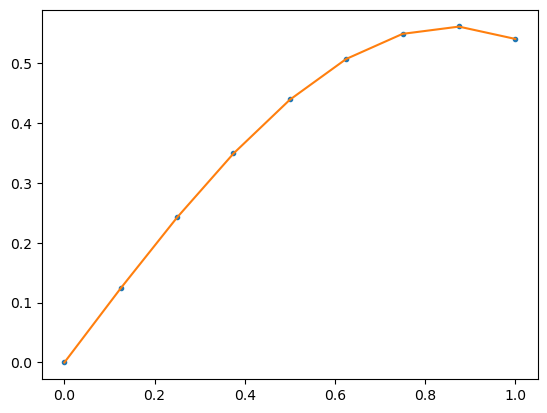

In [4]:
n = 8; interval = [0.0, 1.0];
bc = [0.0, np.cos(1.0)]

startTime = time.time()
u, x, A, B= fem1d_linear(n, interval, c_func, f_func, bc)
endTime = time.time()

u = u.squeeze()
u_real = x * np.cos(x)
pyplot.plot(x, u, '.')
pyplot.plot(x, u_real)
print(f"Time: {endTime - startTime :.5f}s, Error: {np.max( np.abs(u - u_real) )}" )


# Rebuild with ChatGPT

In [2]:
import numpy as np
from scipy import integrate

def fem1d_linear(N, interval, c_func, f_func, bc):
    # unpack interval into variables b and u
    b, u = interval
    # compute size of each subinterval
    h = (u - b) / N

    def fi(x, alpha, xn):
        # definition of hat function
        return ((-1)**alpha) * (xn - h * (alpha - 1) - x) / h

    def fi_1(x, alpha):
        # derivative of hat function
        return ((-1)**alpha) / h

    def A_func(x, alpha, beta):
        # integrand for computing system matrix entries
        return c_func(x) * fi_1(x, alpha) * fi_1(x, beta)

    def B_func(x, beta, xn):
        # integrand for computing right-hand side entries
        return f_func(x) * fi(x, beta, xn)

    # create an array of grid points
    P = np.array([b + n * h for n in range(0, N + 1)])
    # create an array of mesh elements
    T = np.array([range(0, N), range(1, N + 1)])

    # set up the finite element nodes
    Pb = P
    Tb = T

    # initialize the system matrix
    A = np.zeros(shape=(N + 1, N + 1))
    # loop over all mesh elements
    for n in range(0, N):
        # get endpoints of the current mesh element
        x_b = Pb[Tb[0,n]]
        x_u = Pb[Tb[1,n]]
        # loop over all hat functions for current element
        for alpha in range(0, 2):
            for beta in range(0, 2):
                # integrate A_func over current element to compute system matrix entries
                r, _ = integrate.quad(A_func, x_b, x_u, args=(alpha, beta))
                A[Tb[beta, n], Tb[alpha, n]] += r

    # apply boundary conditions to system matrix
    A[0][0] = 1.0
    A[0][1] = 0.0
    A[N][N] = 1.0
    A[N][N - 1] = 0.0

    # initialize the right-hand side
    B = np.zeros(shape=(N + 1, 1))
    # loop over all mesh elements
    for n in range(0, N):
        # get endpoints of the current mesh element
        x_b = Pb[Tb[0,n]]
        x_u = Pb[Tb[1,n]]
        # loop over all hat functions for current element
        for beta in range(0, 2):
            # integrate B_func over current element to compute right-hand side entries
            r, _ = integrate.quad(B_func, x_b, x_u, args=(beta, x_b))
            B[Tb[beta, n], 0] += r

    # apply boundary conditions to right-hand side
    B[0, 0] = bc[0]
    B[N, 0] = bc[1]

    # solve the linear system to obtain the solution coefficients
    coefficients = np.linalg.solve(A, B)

    # return solution coefficients, grid points, system matrix, and right-hand side
    return coefficients, P, A, B



# 函数式编程

In [36]:
class hanshu():
    def __init__(self, func):
        self.func = func
    def __call__(self, *args):
        return self.func(*args)
    def __mul__(self, a):
        def mul(*args):
            return self(*args) * a(*args)
        return hanshu(mul)


In [41]:
def m_add(a, b):
    return a + b
def m_minus(a, b):
    return a - b;
hanshu_add = hanshu(m_add)
hanshu_minus = hanshu(m_minus)

f = hanshu_add * hanshu_minus
f(1, 2) # (1 + 2) * (1 -2) = -3

-3

In [44]:
args = (1, 2)
m_add(*args)

3